# Graphing

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Global parameters
font_size = 15
matplotlib.rc('axes', edgecolor='black')
sns.set(font_scale=font_size/10)

def save_fig(fig, name):
    fig.savefig("../graphs/{}.pdf".format(name))

## Line graphs

In [40]:
def plot_linear(line_data, x_label="Epoch number", y_label="Accuracy", stats_interval=1, 
                legend_loc=0, mark_maxima=False, axis_scales="normal", start=0, figsize=(8, 4),
                ymin=None, ymax=None, use_legend=True, linewidth=1.2):
    """
    line data consists of dicts like:
        values (column)
        xs (optional)
        err_bars (optional)
        label
        colour
        symbol
    """
    fig = plt.figure(figsize=figsize, frameon=True)
    ax = fig.add_subplot(111)
    for line in line_data:
        x = line["xs"][start:] \
            if "xs" in line.keys() \
            else \
            np.arange(start, line["values"][start:].shape[0]+start) * stats_interval
        
        params = {
            "label": line["label"], 
            "c": line["colour"],
            "linewidth": linewidth,
            "linestyle": line["linestyle"] if "linestyle" in line.keys() else '-'
        }
        y = line["values"][start:]
        if axis_scales == "logx":
            ax.semilogx(x, y, **params)
        elif axis_scales == "logy":
            ax.semilogy(x, y, **params)
        elif axis_scales == "log":
            ax.loglog(x, y, **params)
        else:
            ax.plot(x, y, **params)
            if "err_bars" in line.keys():
                ax.errorbar(x, y, yerr=line["err_bars"], xerr=None, fmt='none', 
                            ecolor=line["colour"], capsize=3, elinewidth=1)
        
        if mark_maxima:
            max_x = x[np.argmax(y)]
            max_y = np.amax(y)
            params = {
                "c": line["colour"],
                "markersize": 10
            }
            if axis_scales == "logx":
                ax.semilogx(max_x, max_y, "x", **params)
            elif axis_scales == "logy":
                ax.semilogy(max_x, max_y, "x", **params)
            elif axis_scales == "log":
                ax.loglog(max_x, max_y, "x", **params)
            else:
                ax.plot(max_x, max_y, "x", **params)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
    
    ax.tick_params(axis='both', which='both', size=6, labelcolor='black', color='black', labelsize=font_size)
    
    if ymin is not None:
        plt.ylim(bottom=ymin)
    if ymax is not None:
        plt.ylim(top=ymax)
        
    if use_legend:
        legend = ax.legend(loc=legend_loc, frameon=1, prop={'size': font_size})
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('black')
    
        for legobj in legend.legendHandles:
            legobj.set_linewidth(2.0)
    
    ax.set_xlabel(x_label, fontsize=font_size, color='black')
    ax.set_ylabel(y_label, fontsize=font_size,  color='black')
    ax.set_facecolor('#FFFFFF')
    plt.tight_layout()
    
    return fig

# fig = plot_linear(data_line, x_label="Epoch", y_label="Accuracy", mark_maxima=True)
# save_fig(fig=fig, name="sample_linear_graph")

## Heatmaps

In [4]:
def plot_heatmap(values, xs, ys, x_label, y_label, height=None, cmap=None, logColourbar=False, 
                 scale_label=r"$acc_{val}$", scale_format="%.3f", min_v=None, max_v=None, title=None):
    if cmap is None:
        cmap = 'seismic'
    if logColourbar:
        norm = LogNorm(vmin=np.amax(values), vmax=np.amin(values))
    else:
        norm = None
    width = 1.0*len(xs) + 3
    if height is None:
        height = (width - 6)*(len(ys)*1.0/(len(xs)*1.0))
    cbar_kws = {
        "pad": 0.01,
        "format": scale_format,
        "label": scale_label
    }
        
    fig = plt.figure(figsize=(width, height), frameon=True, edgecolor='blue')
    ax = fig.add_subplot(111)
    ax = sns.heatmap(values, vmin=min_v, vmax=max_v, cmap=cmap, center=None, robust=True, 
                annot=True, fmt='.3g', annot_kws={"fontsize": font_size}, linewidths=0, linecolor='black', 
                cbar=True, cbar_kws=cbar_kws, cbar_ax=None, square=False, 
                xticklabels=xs, yticklabels=ys, mask=None, ax=ax,
                norm=norm)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
    
#     ax.ticklabel_format(axis='x', style='scientific')
    ax.tick_params(axis='both', which='both', size=6, labelcolor='black', color='black', labelsize=font_size)   
    ax.set_xlabel(x_label, fontsize=font_size, color='black')
    ax.set_ylabel(y_label, fontsize=font_size,  color='black')
    ax.set_title(title)
    ax.set_facecolor('#FFFFFF')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return fig

# fig = plot_heatmap(**data_heat)
# save_fig(fig=fig, name="sample_heatmap_graph")

In [5]:
def columns_to_heatmap(cols):
    cols = np.array(cols)
    x_vals = np.unique(cols[:, 0])
    y_vals = np.unique(cols[:, 1])
    reshaped = np.array([[[r[2] for r in cols if r[0]==x and r[1]==y][0] for x in x_vals ] for y in y_vals])
    return reshaped, x_vals, y_vals

## Peculiar 3D graphs

In [6]:
def plot_weird_3d(data, w=15, h=3.5, x_label="Y", y_label="(x_1, x_2) ranges", 
                  scale_label="performance", axis_scales="normal", colourmap="RdYlGn",
                  colourScale=None):
    ys = np.unique(data[:, 2])
    N = len(ys) # number of groups
    M = len(data)/len(ys) # number of columns per group
    z_min = np.amin(data[:,3])
    z_max = np.amax(data[:,3])
#     print("{} < z < {}".format(z_min, z_max))
    # print("{} groups of {} columns".format(N, M))
    width = 0.1 # the width of the bars
    gap = 0.2 # gap between groups of bars
    fig = plt.figure(figsize=(w, h), frameon=True)
    ax = fig.add_subplot(111)
    plots = []
    cmap = matplotlib.cm.get_cmap(colourmap)

    for i, y in enumerate(ys):
        samples = np.array([r for r in data if r[2] == y])
    #     samples = sorted(samples, key=lambda s: s[3]) # sort by performance
        samples = sorted(samples, key=lambda s: s[1] - s[0]) # sort by span
    #     samples = sorted(samples, key=lambda s: s[0]) # sort by min
    #     samples = sorted(samples, key=lambda s: s[1]) # sort by max

        locs = np.arange(M)*width + i*(M*width + gap) # locations of columns
        mins = [s[0] for s in samples]
        maxes = [s[1] for s in samples]
        zs = np.array([s[3] for s in samples])
        if colourScale is None:
            shades = (zs - z_min)/(z_max - z_min)
        elif colourScale == "log":
            shades = (zs - z_min)/(z_max - z_min)
#             print("normalised shades:{}".format(shades))
            epsilon = 0.0001
            shades = -(1-epsilon)*shades + 1 + epsilon
#             print("shades now go from {} down to {}".format(np.amax(shades), np.amin(shades)))
#             print(shades)
#             print(z_max - z_min)
            max_log = -np.log(epsilon)
#             print("Log goes up to {}".format(max_log))
            shades = -np.log(shades)/max_log
#             print(np.amin(shades), np.amax(shades))
        colours = [cmap(shade) for shade in shades]
        plots.append(plt.bar(locs, maxes, width, bottom=mins, color=colours))

    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(z_min, z_max))
    sm.set_array([])
    cbar = plt.colorbar(sm, pad=-0.01)
    cbar.set_label(scale_label, rotation=270, labelpad=30)

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')

    ax.tick_params(axis='both', which='both', size=6, labelcolor='black', color='black', labelsize=font_size)
    ax.set_facecolor('#FFFFFF')

    locs = np.arange(N)*(M*width + gap) + (M*width + gap)/2
    plt.ylabel(y_label, fontsize=font_size,  color='black')
    plt.xlabel(x_label, fontsize=font_size, color='black')
    plt.xticks(locs, [str(y) for y in ys])
    plt.yticks(rotation=0)
    
    if axis_scales is None:
        pass
    elif axis_scales == "logy":
        ax.set_yscale("log")

    plt.tight_layout()
    return fig

## Log-reg tuning

Let's see the best config overall:

In [7]:
max_steps_vals = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
normalizer_vals = [0, 0.00001, 0.0001, 0.001, 0.01]
mix_up_vals = [19, 50, 100, 150, 200, 250, 300]

# max-steps,normaliser,mix-up,acc,c_prim

file_path = "log-reg-gridsearch3D.log"
grid_search_stats = pd.read_csv(file_path)
c_min = grid_search_stats["c_prim"].min()
c_max = grid_search_stats["c_prim"].max()

best_row_index = grid_search_stats["c_prim"].idxmin()
best_config = grid_search_stats.iloc[best_row_index]
print("Best values:\n{}".format(best_config))

Best values:
max-steps     100.000
normaliser      0.001
mix-up        100.000
acc             0.898
c_prim          0.136
Name: 163, dtype: float64


Okay, so this is the best one. But let's look at it more closely.

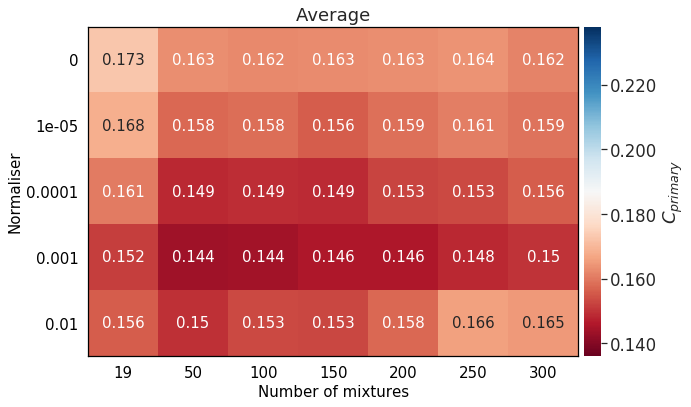

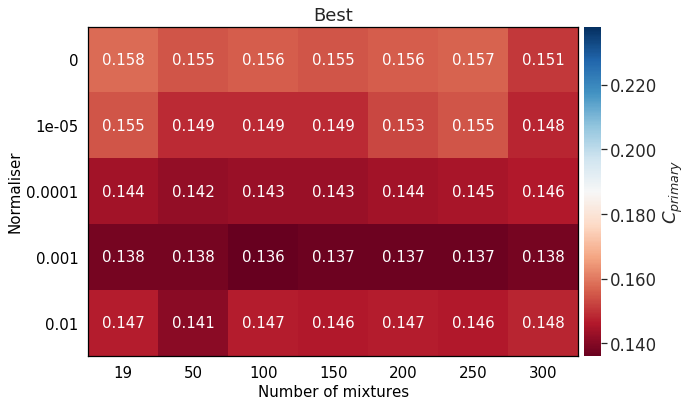

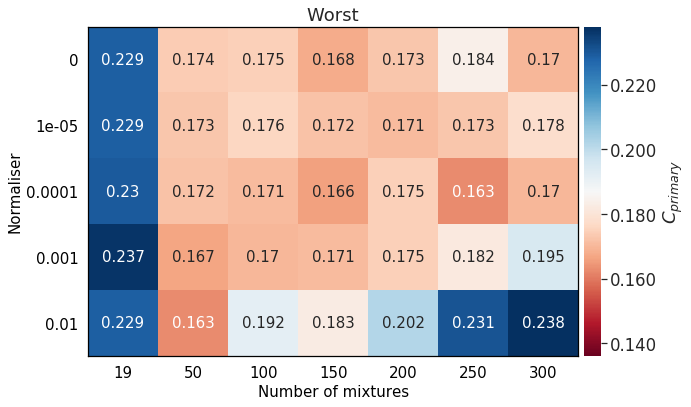

In [8]:
matrices = np.zeros((len(max_steps_vals), len(normalizer_vals), len(mix_up_vals)))

for i, max_step_val in enumerate(max_steps_vals):
    title = "C_primary dependent on normaliser and mix-up values for max-steps = {}".format(max_step_val)
    stats = grid_search_stats[grid_search_stats["max-steps"] == max_step_val]
    matrix = np.array([
                [
                    stats[(stats["mix-up"] == mix_up) & (stats["normaliser"] == norm)]["c_prim"].item()
                    for mix_up in mix_up_vals
                ] 
                for norm in normalizer_vals
             ])
    matrices[i] = matrix
    
fig = plot_heatmap(np.average(matrices, axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="Normaliser", x_label="Number of mixtures",
             height=6, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max, title="Average")
fig = plot_heatmap(matrices.min(axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="Normaliser", x_label="Number of mixtures",
             height=6, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max, title="Best")
fig = plot_heatmap(matrices.max(axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="Normaliser", x_label="Number of mixtures",
             height=6, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max, title="Worst")

Okay, looks like normaliser=0.001 is a clear winner. Now what about the other two params?

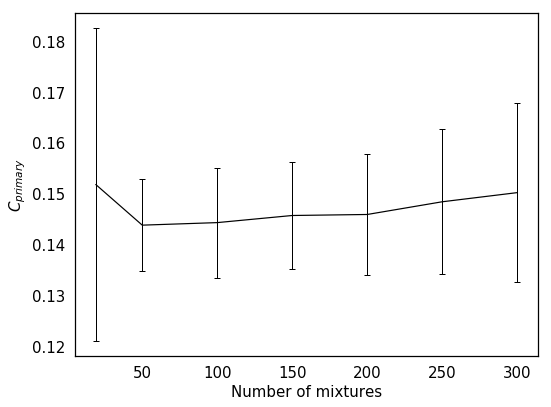

In [44]:
stats_for_fixed_normaliser = []

for mix_up_val in mix_up_vals:
    data_points = grid_search_stats[(grid_search_stats["normaliser"] == 0.001) & (grid_search_stats["mix-up"] == mix_up_val)]["c_prim"]
    mean = data_points.mean()
    stdev = data_points.std()
    stats_for_fixed_normaliser.append(np.array([mean, stdev]))

    data_line =[{
        "values": np.array(stats_for_fixed_normaliser)[:, 0],
        "xs": mix_up_vals,
        "err_bars": np.array(stats_for_fixed_normaliser)[:, 1],
        "label": None,
        "colour": "black",
        "symbol": "x"
    }]
    
fig = plot_linear(data_line, x_label="Number of mixtures", y_label="$C_{primary}$", 
                legend_loc=0, mark_maxima=False, axis_scales="normal", figsize=(8, 6),
                ymin=None, ymax=None, use_legend=False)

Cool, looks like numer of mixtures could be 50 or 100.

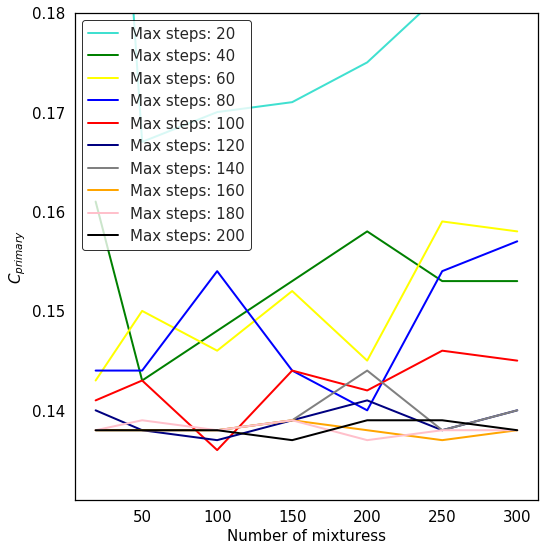

In [46]:
data_line = []
colours = ['turquoise', 'green', 'yellow', 'blue', 'red', 'navy', 'gray', 'orange', 'pink', 'black']
for i, max_steps_val in enumerate(max_steps_vals):
    data_points = grid_search_stats[(grid_search_stats["normaliser"] == 0.001) & (grid_search_stats["max-steps"] == max_steps_val)]["c_prim"]
    data_line.append({
        "values": data_points,
        "xs": mix_up_vals,
        "label": "Max steps: {}".format(max_steps_val),
        "colour": colours[i],
    })

fig = plot_linear(data_line, x_label="Number of mixturess", y_label="$C_{primary}$", 
                legend_loc=0, mark_maxima=False, axis_scales="normal", figsize=(8, 8),
                ymin=None, ymax=0.18, linewidth=2)

It's clear now that the more steps, the more stable curve. That's what we want. Let's go with max-steps=200. And number of mixtures doesn't seem to matter too much, so let's use the smallest value that gives good results for high numbers of steps. That's 100.

To recap: `normaliser=0.001, max-steps=200, mix-up=100`.